<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Выполним необходимые импорты.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error


Загрузим имеющийся датасет.

In [2]:
try:
    df = pd.read_csv(r'C:\Users\Марина\Downloads\taxi.csv',index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Проведем ресемплирование данных по одному часу.

In [4]:
df.sort_index(inplace=True)
df =  df.resample('1H').sum()

Выведем основную информацию по имеющимся данным.

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


<b> Вывод </b>: На данном этапе был загружен имеющийся датасет, выведена основная информация по нему. 
Пропусков в данных нет. Проведено ресемплирование данных по 1 часу. Выборка состоит из 4416 наблюдений о количестве заказов такси каждый час за период с 1 марта 2018 года по 31 августа 2018 года. Можно перейти к дальнейшему анализу.

## Анализ

Посмотрим на распределение количества заказов такси в заданном временном промежутке. Также посмотрим на изменение скользящего среднего имеющегося временного ряда.

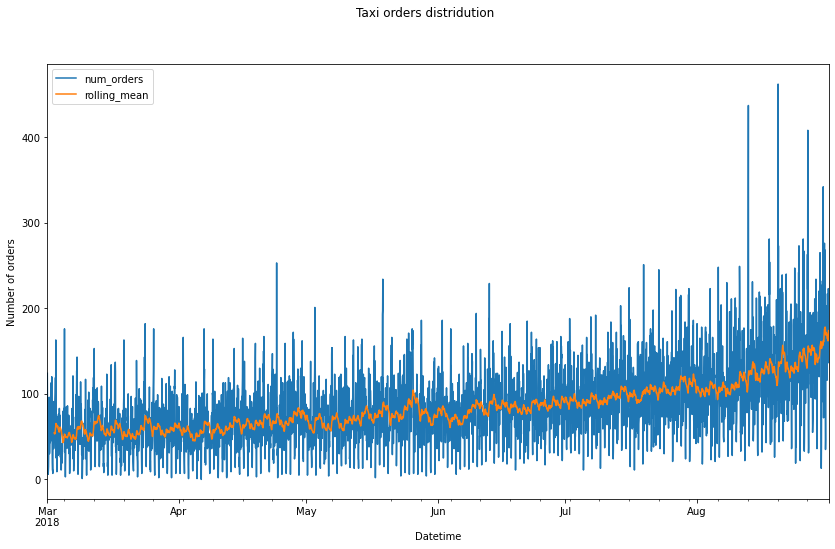

In [8]:
df_copy = df.copy()
df_copy['rolling_mean'] = df_copy.rolling(40).mean() 
df_copy.plot(figsize = (14,8))
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.suptitle("Taxi orders distridution")
plt.show()

Судя по графику, есть тенденция к увеличению общего числа заказов (наглядно видно на графике скользящнго среднего временного ряда). Посмотрим на тренд, сезонность и остатки.

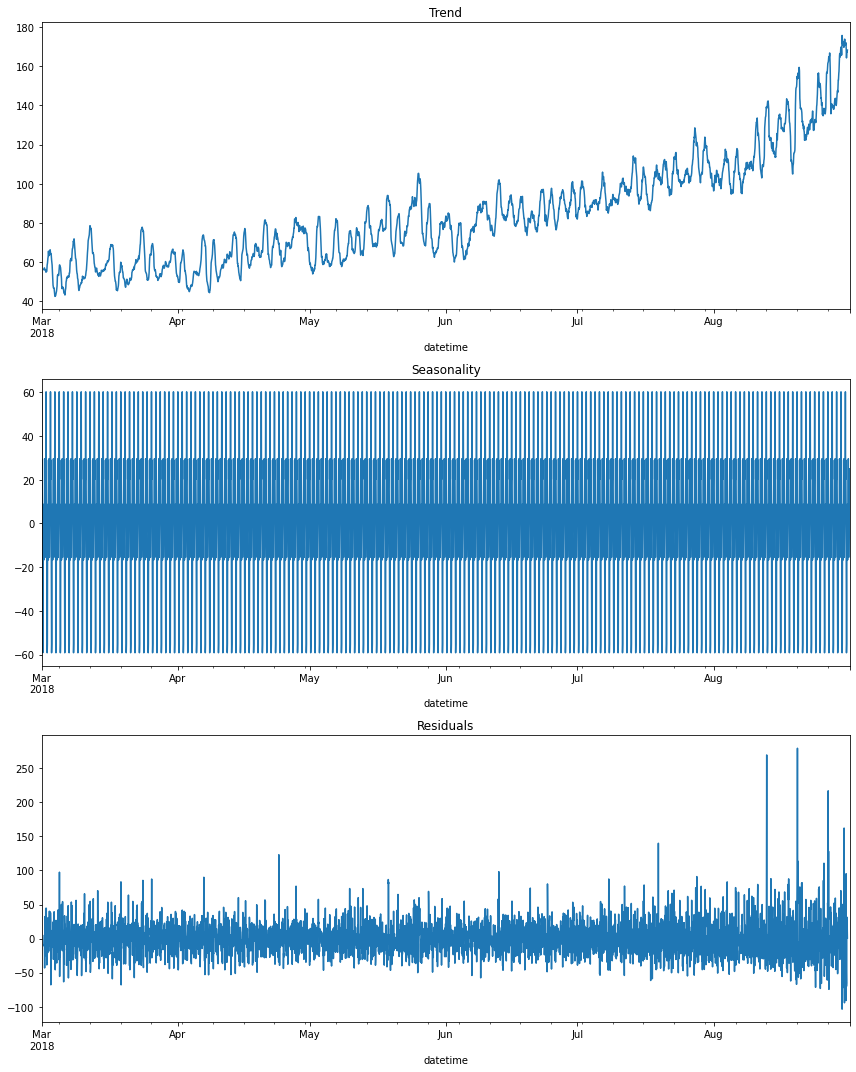

In [9]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(12, 15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Есть тренд к росту числа заказов с марта по август, а сезонность нужно рассмотреть на более коротком временном промежутке. Попробуем посмотреть на сезонную составляющую в недельном разрезе.

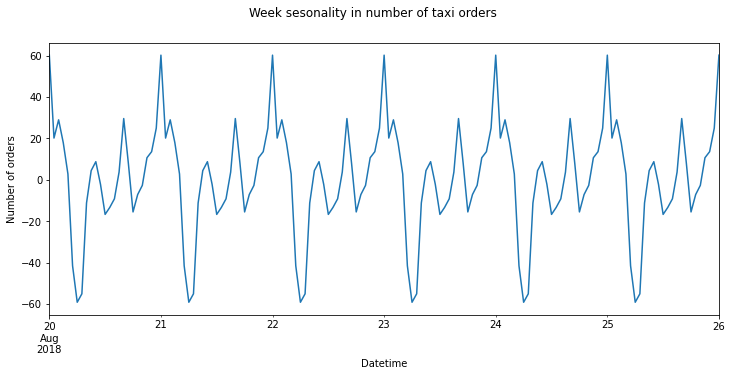

In [10]:
decomposed.seasonal['2018-08-20':'2018-08-26 00:00:00'].plot(figsize=(12,5))
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.suptitle("Week sesonality in number of taxi orders")
plt.show()

Видно, что сезонность нужно рассмотреть еще на более коротком промежутке времени. Построим график за день.

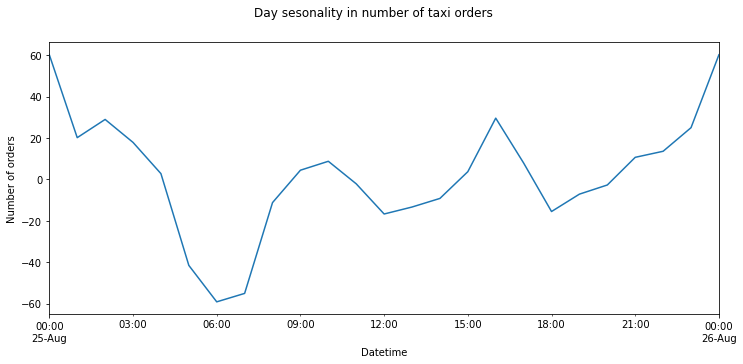

In [11]:
decomposed.seasonal['2018-08-25 00:00:00':'2018-08-26 00:00:00'].plot(figsize=(12,5))
plt.xlabel('Datetime')
plt.ylabel('Number of orders')
plt.suptitle("Day sesonality in number of taxi orders")
plt.show()

Теперь наглядно видим, что в течение дня есть "пиковые" часы заказа такси, это ночное время, а также несколько часов в середине дня.

Проверим ряд на стационарность при помощи критерия Дики-Фуллера.

Нулевая гипотеза H0: "Ряд нестационарный"

Альтернативная гипотеза H1: "Ряд стационарный"

In [12]:
pvalue = adfuller(df)[1]

print('Значение pvalue =', pvalue)

Значение pvalue = 0.028940051402614794


Возмем уровень значимости равным 5% (alpha = 0.05)

In [13]:
alpha = 0.05

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

Отвергаем нулевую гипотезу


Удалось отвергнуть нулевую гипотезу, то есть имеющийся временной ряд можно считать стационарным.

Создадим дополнительные признаки.

In [14]:
# функция для создания дополнительных признаков в датасете

def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df  = df.dropna()
    
    return df


Выберем произвольные значения max_lag и rolling_mean_size, создадим признаки.

In [15]:
df = make_features(df, 48, 20)
display(df.head())

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,3,5,72.0,119.0,101.0,93.0,49.0,89.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,57.85
2018-03-03 01:00:00,108,3,3,5,163.0,72.0,119.0,101.0,93.0,49.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.00
2018-03-03 02:00:00,25,3,3,5,108.0,163.0,72.0,119.0,101.0,93.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,69.85
2018-03-03 03:00:00,64,3,3,5,25.0,108.0,163.0,72.0,119.0,101.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,70.55
2018-03-03 04:00:00,44,3,3,5,64.0,25.0,108.0,163.0,72.0,119.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,73.40


Выделим признаки и целевой показатель. Разделим выборку на обучающую и тестовую в соотношении 90% : 10% соответственно.

In [16]:
features = df.drop(['num_orders'], axis=1)
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, \
                                                                            test_size = 0.1, random_state = 123)


Проверим корректность разделения выборки.

In [17]:
print('Диапазон индексов обучающей выборки:', features_train.index.min(), features_train.index.max() )
print('Диапазон индексов тестовой выборки:', features_test.index.min(), features_test.index.max() )

Диапазон индексов обучающей выборки: 2018-03-03 00:00:00 2018-08-13 18:00:00
Диапазон индексов тестовой выборки: 2018-08-13 19:00:00 2018-08-31 23:00:00


In [18]:
print(features_train.shape[0])
print(features_test.shape[0])

3931
437


<b> ВЫВОД </b>: 

  На данном этапе исследования:
  - изучены трендовая и сезонная составляющие данных, а такде остатки. 
  Есть тренд к росту общего числа заказов за имеющийся промежуток времени, сезонность лучше всего оценивать за дневной отрезок времени.
  
  - ряд проверен на нестационарность при помощи критерия Дики-Фуллера. 
  Нулевую гипотезу удалось отвергнуть, имеющийся временной ряд можно считать стационарным.
  
  - созданы дополнительные признаки, которые будут необходимы при построении модели, а также проведено корректное разделение выборки на обучающую и тестовую части.
        
   Можно переходить к непосредственному обучению моделей.

## Обучение

Построим четыре различные регрессионные модели:
    
    - LinearRegression
    - RandomForestRegressor
    - CatBoostREgressor
    - LightGBMRegressor
 

Подберем гиперпараметры, все полученнные результаты метрик RMSE по лучшим моделям запомним с целью дальнейшего сравнения и выбора наилучшей.

In [19]:
#список для хранения метрик RMSE по наилучшим обученным моделям каждого типа

results_rmse = []

### Linear Regression

In [20]:
%%time

model_lr = LinearRegression()

features_train_lr = features_train.copy()
target_train_lr = target_train.copy()

tscv = TimeSeriesSplit(test_size = features_train_lr.shape[0]//10)

scores = cross_val_score(model_lr, features_train_lr, target_train_lr, scoring ='neg_root_mean_squared_error', cv = tscv)
RMSE_lr = (abs(scores).mean())

print('RMSE_Linear_Regression = ', RMSE_lr.round(3))

results_rmse.append(RMSE_lr.round(3))

RMSE_Linear_Regression =  26.35
CPU times: total: 219 ms
Wall time: 167 ms


### RandomForestRegressor

In [21]:
%%time 

model_rf = RandomForestRegressor(random_state = 123)
features_train_rf = features_train.copy()
target_train_rf = target_train.copy()

params =  {'n_estimators': range(10, 80, 2), 
           'max_depth': [3, 5, 7]}

rf = GridSearchCV(model_rf, params, scoring = 'neg_root_mean_squared_error', cv = TimeSeriesSplit(), n_jobs = -1)
rf.fit(features_train_rf, target_train_rf)
rf_best =  rf.best_estimator_

print('Наилучшая модель RandomForest:', rf.best_params_)
print(f'RMSE_random_forest = {abs(rf.best_score_).round(3)}')

results_rmse.append(abs(rf.best_score_).round(3))

Наилучшая модель RandomForest: {'max_depth': 7, 'n_estimators': 66}
RMSE_random_forest = 25.329
CPU times: total: 10.3 s
Wall time: 6min 31s


### CatBoost

In [22]:
model = CatBoostRegressor(verbose = False, random_state = 123)
features_train_cb = features_train.copy()
target_train_cb = target_train.copy()

params = { 'iterations': [50, 70, 100],
            'learning_rate': [0.1, 0.2],
            'depth': [4, 7, 10]}

cat_boost = GridSearchCV(model, params, cv = TimeSeriesSplit(), scoring='neg_root_mean_squared_error', n_jobs = -1)
cat_boost.fit(features_train_cb, target_train_cb)
cat_boost_best = cat_boost.best_estimator_

print('Наилучшая модель CatBoost:', cat_boost.best_params_)
print(f'RMSE_cat_boost = {abs(cat_boost.best_score_).round(3)}')

results_rmse.append(abs(cat_boost.best_score_).round(3))

Наилучшая модель CatBoost: {'depth': 7, 'iterations': 100, 'learning_rate': 0.2}
RMSE_cat_boost = 24.152


### LightGBM

In [23]:
%%time

model = LGBMRegressor(random_state = 123)
features_train_lgb = features_train.copy()
target_train_lgb = target_train.copy()

params = { 'max_depth': [5, 7, 10],
           'learning_rate': [0.1, 0.15, 0.2],
           'n_estimators': [50, 70, 100]}

lgbm  = GridSearchCV(model, params, cv = TimeSeriesSplit(), scoring='neg_root_mean_squared_error')
lgbm.fit(features_train_lgb, target_train_lgb)
lgbm_best = lgbm.best_estimator_

print('Наилучшая модель LightGBM:', lgbm.best_params_)
print(f'RMSE_lgbm = {abs(lgbm.best_score_).round(3)}')

results_rmse.append(abs(lgbm.best_score_).round(3))

Наилучшая модель LightGBM: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
RMSE_lgbm = 24.277
CPU times: total: 1min 14s
Wall time: 23.6 s


Сравним результаты полученных метрик RMSE по каждой из рассмотренных моделей.

In [24]:
results = pd.DataFrame({'Model': ['Linear_Regression', 'Random_Forest_Regressor', 'CatBoost_Regressor', 'Light_GBM_Regressor'], 
                        'RMSE_train': results_rmse})
display(results)

,Model,RMSE_train
0,Linear_Regression,26.350
1,Random_Forest_Regressor,25.329
2,CatBoost_Regressor,24.152
3,Light_GBM_Regressor,24.277


<b> Вывод:</b> 
 
 На данном этапе проведено моделирование с использованием 4 типов моделей:
    
    - LinearRegression
    - RandomForestRegressor
    - CatBoostREgressor
    - LightGBMRegressor
 
 Для моделей градиентного бустинга и случайного леса осуществлен поиск наилучших гиперпараметров.

Наилучший результат показала модель CatBoostRegressor. Далее проведем оценку качества ее работы на тестовой выборке.

## Тестирование

Подсчитаем метрику RMSE наилучшей модели на тестовой выборке.

In [29]:
cat_boost_best.fit(features_train, target_train)
predictions = cat_boost_best.predict(features_test)

rmse_test = mean_squared_error(target_test, predictions, squared = False)
print(rmse_test)

39.3611615894025


Визуализируем результат работы модели на тестовых данных. Возьмем данные за 3 последние дня, чтобы лучше оценить работу модели в "пиковые" часы нагрузки на сервис такси.

In [36]:
predictions = pd.Series(index = target_test.index, data = predictions)
predictions.tail()

datetime
2018-08-31 19:00:00    143.730193
2018-08-31 20:00:00    165.683093
2018-08-31 21:00:00    179.858895
2018-08-31 22:00:00    166.562394
2018-08-31 23:00:00    163.678352
Freq: H, dtype: float64

In [37]:
target_test.tail()

datetime
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, dtype: int64

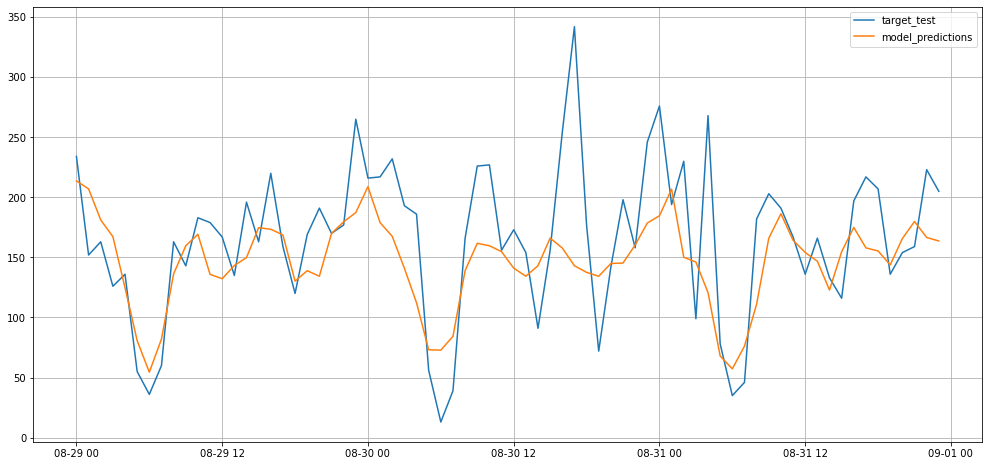

In [51]:
plt.figure(figsize=(17,8))
plt.plot(target_test['2018-08-29 00:00:00':'2018-08-31 23:00:00'], label = 'target_test')
plt.plot(predictions['2018-08-29 00:00:00':'2018-08-31 23:00:00'], label = 'model_predictions')
plt.legend()
plt.grid()
plt.show()

Судя по графику, модель неплохо справляется с оценкой объема заказов в утреннее время (с 6 до 12) и хуже всего работает с пиковыми значениями в вечернее время (16-18 часов). Ночные "колебания" числа заказов точно предсказать удается не всегда.

Сравним результат полученной метрики с результатом дамми-регрессора, предсказывающим среднее значение числа заказов.

In [ ]:
model = DummyRegressor(strategy='mean')
model.fit(features_train, target_train)
predictions_dummy = model.predict(features_test)
rmse_dummy = mean_squared_error(target_test, predictions_dummy, squared = False)
print(rmse_dummy)

Удалось достичь значения метрики RMSE на тестовых данных менее 48. Модель адекватна поставленной задаче, успешно прошла сравнение с дамми-регрессором.

## Итоговый вывод

Целью исследования было построение модели регрессии для предсказания количество заказов такси на следующий час.

Модель регресии должна быть выбрана на основе качества предсказания: метрики RMSE, которая должна быть не выше 48.

В ходе проекта:
   - проанализированы имеющиеся данные, выявлены закономерности: тренд, сезонность, остатки
   - осуществлена подготовка данных к моделированию: проверка ряда на стационарность, добавление необходимых признаков
   - построены 4 модели регресии, подобраны гиперпараметры, изучена интересующая метрика качества предсказания.
   - выбрана наиболее адекватная поставленной задаче модель, ей оказалась модель CatBoost с подобранными гиперпараметрами
   - осуществлена проверка модели на тестовых данных
   - проведено сравнение с дамми-регрессором.
   - получены результаты, удовлетворяющие поставленным задачам.